In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

## load dump file

In [2]:
def load_lammps_dump(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Find the number of particles
    for i, line in enumerate(lines):
        if line.startswith('ITEM: NUMBER OF ATOMS'):
            num_particles = int(lines[i+1].strip())
            break
        
        # Find the box dimensions
    for i, line in enumerate(lines):
        if line.startswith('ITEM: BOX BOUNDS'):
            box_bounds = [list(map(float, bounds.split())) for bounds in lines[i+1:i+4]]
            break

    # Find the starting line of the atomic positions
    start_lines = []
    for i, line in enumerate(lines):
        if line.startswith('ITEM: ATOMS'):
            start_line = i + 1
            start_lines.append(start_line)

    # Initialize arrays to store the data
    ntime = len(start_lines)
    positions = np.zeros((ntime, num_particles, 3))
    atom_ids = np.zeros(num_particles, dtype=int)
    atom_types = np.zeros(num_particles, dtype=int)
    
    # atom id and type
    start_line_0 = start_lines[0]
    for i in range(num_particles):
        line = lines[start_line_0+i]
        data = line.split()
        atom_ids[i] = int(data[0])
        atom_types[i] = int(data[1])

    # Parse the atomic positions, atom IDs, and atom types
    for it, start_line_t in tqdm(enumerate(start_lines)):
        for i in range(num_particles):
            line = lines[start_line_t+i]
            data = line.split()
            positions[it, i, :] = [float(data[2]), float(data[3]), float(data[4])]

    return positions, atom_ids, atom_types, box_bounds


In [16]:
positions_list = []
temperature_list = [810,870,910,950]
for temp in temperature_list:
    positions, atom_ids, atom_types, box_bounds = load_lammps_dump(f"./out_vacancy_cube8_{temp:d}.dump")
    positions_list.append(positions)    

100001it [03:28, 479.02it/s]
100001it [03:29, 476.34it/s]
100001it [03:41, 452.06it/s]
100001it [03:42, 449.36it/s]


# calculate MSD

In [17]:
n_t0 = 10
n_times = positions_list[0].shape[0]
n_times_msd = 10000

n_particles = len(atom_ids)

msd = np.zeros(n_times_msd)
t_list = np.arange(n_times_msd)
t0_list = np.arange(n_t0)*n_times_msd

msd_list = []
for positions in positions_list:
    for it0, t0 in enumerate(t0_list):
        position_0 = positions[t0]
        for it, t in (enumerate(t_list)):
            position_t = positions[t0+t]
            msd_t = np.sum((position_t-position_0)**2)/n_particles
            msd[it] += msd_t    
    msd = msd/n_t0
    msd_list.append(msd)


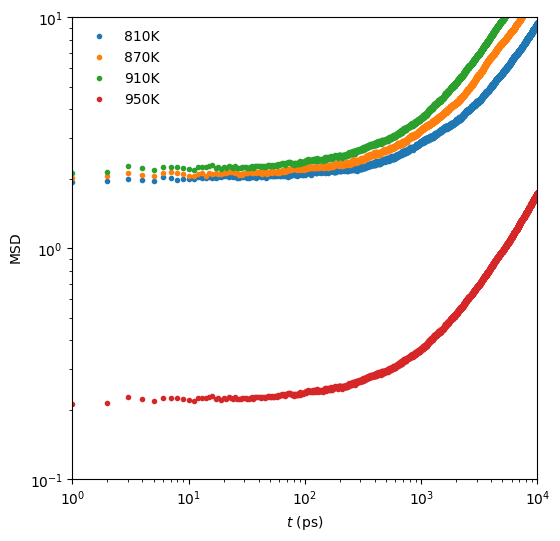

In [27]:
timestep = 1
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

for i_temp, temperature in enumerate(temperature_list):
    msd = msd_list[i_temp]
    ax.plot(t_list[1:]*timestep,msd[1:],".", label=str(temperature)+"K")


ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e-1,10])
ax.set_xlim([1,1e4])

ax.set_xlabel(r"$t$ (ps)")
ax.set_ylabel(r"$\rm{MSD}$")
ax.legend(frameon=False)
plt.show()